# hugs demo

This notebook contains a brief demo showing how to use tools from $hugs$ to process HSC calibrated exposures and detect sources using $SExtractor$.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

import lsst.afw.image

from hugs import primitives as prim
import hugs

## Load calibrated exposure
- For this demo, I downloaded a calibrated exposure for a random patch from the [HSC DR1 website](https://hsc-release.mtk.nao.ac.jp)

In [2]:
exposure = lsst.afw.image.ExposureF('/tigress/jgreco/calexp-HSC-I-9451-2,6.fits')
mi = exposure.getMaskedImage()
mask = exposure.getMask()

## Calculate PSF and smooth image at this scale

In [3]:
psf_sigma = hugs.utils.get_psf_sigma(exposure)
mi_smooth = hugs.imtools.smooth_gauss(mi, psf_sigma)

## Low and High thresholding
 - perform two levels of thresholding to identify diffuse light associated with bright sources
 - new mask planes will be added to the exposure mask

In [4]:
fpset_low = prim.image_threshold(mi_smooth, 
                                 thresh=3.0,
                                 mask=mask, 
                                 plane_name='THRESH_LOW',
                                 rgrow=4)

fpset_high = prim.image_threshold(mi_smooth, 
                                 thresh=30.0,
                                 mask=mask, 
                                 plane_name='THRESH_HIGH',
                                 rgrow=4)

## Image cleaning
- replace bright sources and their associated diffuse light with sky noise

In [5]:
exp_clean = prim.clean(exposure, fpset_low, rgrow=4, max_frac_high_thresh=0.15)

Below I define some functions to visualize the cleaning step:

In [6]:
def show_step(img, ax, vmin, vmax, title, seg=None, alpha=0.6, cmap=plt.cm.gnuplot):
    
    ax.imshow(img, cmap='gray_r', vmin=vmin, vmax=vmax, origin='lower')
    
    if seg is not None:
        if type(seg) is not list:
            seg = [seg]
        if type(alpha) is not list:    
            alpha = [alpha]*len(seg)  
        for s, a in zip(seg, alpha): 
            ax.imshow(s, alpha=a, cmap=cmap, vmin=0, vmax=1, origin='lower')
            
    ax.set_title(title, fontsize=15)
            
def get_fp_array(fpset):
    seg = fpset.insertIntoImage(True).getArray().copy()
    seg = seg.astype(float)
    seg[seg==0] = np.nan
    seg[~np.isnan(seg)] = 1.0
    return seg

zscale = ZScaleInterval()

Convert the exposure and low/high threshold footprints to numpy arrays for plotting

In [7]:
img = exposure.getImage().getArray()
img_clean = exp_clean.getImage().getArray()
seg_high = get_fp_array(fpset_high)
seg_low = get_fp_array(fpset_low)
vmin, vmax = zscale.get_limits(img)

Plot the results. The middle panel shows the segmentation maps from the thresholding step. 

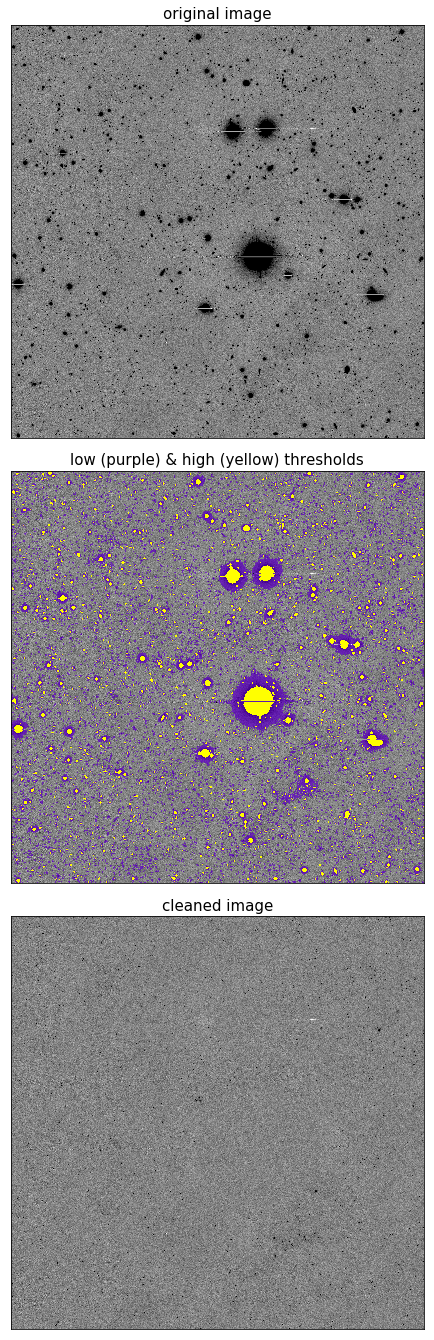

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(8, 24), 
                         subplot_kw=dict(xticks=[], yticks=[], aspect='equal'))
fig.subplots_adjust(hspace=0.08)
show_step(img, axes[0], vmin, vmax, 'original image')
show_step(img, axes[1], vmin, vmax, 'low (purple) & high (yellow) thresholds', 
          [seg_low*0.15, seg_high*1], [0.7, 1])
show_step(img_clean, axes[2], vmin, vmax, 'cleaned image')

## Source detection
- detect sources in cleaned image using $SExtractor$
- you need to create an input/output directory for $SExtractor$

In [9]:
sex_config = dict(DETECT_THRESH=0.7, 
                  MAG_ZEROPOINT=27.0,
                  DETECT_MINAREA=100,
                  FILTER_NAME='../hugs/sextractor/config/gauss_6.0_31x31.conv',
                  PHOT_APERTURES='3,4,5,6,7,8,16,32,42,54')
sex_io_dir = '/scratch/network/jgreco/sextractor-io'

sources = prim.detect_sources(exp_clean, sex_config, sex_io_dir, label='demo')


running 
-------
sex -c /home/jgreco/projects/hugs/hugs/sextractor/config/default.sex /scratch/network/jgreco/sextractor-io/exp-demo-i.fits[1] -CATALOG_NAME /scratch/network/jgreco/sextractor-io/sex-demo-i.cat -PARAMETERS_NAME /home/jgreco/projects/hugs/hugs/sextractor/config/hugs-sextractor.param -MAG_ZEROPOINT 27.0 -PHOT_APERTURES 3,4,5,6,7,8,16,32,42,54 -DETECT_THRESH 0.7 -DETECT_MINAREA 100 -FILTER_NAME ../hugs/sextractor/config/gauss_6.0_31x31.conv



The source catalog is an astropy table. $SExtractor$ measures the following parameters:

In [10]:
sources.colnames

['x_image',
 'y_image',
 'ra',
 'dec',
 'mag_auto_i',
 'magerr_auto_i',
 'kron_radius',
 'flux_radius_i',
 'mag_petro_i',
 'magerr_petro_i',
 'petro_radius',
 'a_image',
 'b_image',
 'theta_image',
 'ellipticity',
 'fwhm_i',
 'mag_ap0_i',
 'mag_ap1_i',
 'mag_ap2_i',
 'mag_ap3_i',
 'mag_ap4_i',
 'mag_ap5_i',
 'mag_ap6_i',
 'mag_ap7_i',
 'mag_ap8_i',
 'mag_ap9_i',
 'magerr_ap0_i',
 'magerr_ap1_i',
 'magerr_ap2_i',
 'magerr_ap3_i',
 'magerr_ap4_i',
 'magerr_ap5_i',
 'magerr_ap6_i',
 'magerr_ap7_i',
 'magerr_ap8_i',
 'magerr_ap9_i',
 'flags',
 'x_hsc',
 'y_hsc',
 'ebv',
 'A_i']

Let's look at the size and mag distribution for sources within this particular patch:

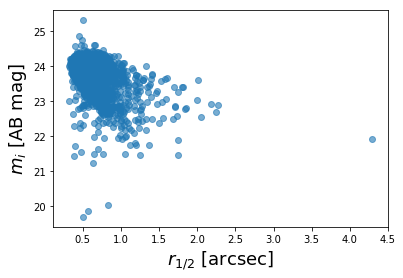

In [11]:
plt.scatter(sources['flux_radius_i'], sources['mag_auto_i'], alpha=0.6)
plt.ylabel(r'$m_i$ [AB mag]', fontsize=18)
plt.xlabel(r'$r_{1/2}$ [arcsec]', fontsize=18);